## Настя Шабаева, БКЛ181

### Домашняя работа №1

#### Импортируем необходимые пакеты

In [166]:
import pandas as pd
from langdetect import detect

import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.corpus import stopwords

from string import punctuation
punctuation += '...' + '—' + '…' + '«»'

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer1 = TfidfVectorizer()
from sklearn.feature_extraction.text import CountVectorizer
vectorizer2 = CountVectorizer()
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold
from sklearn.metrics import *
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package wordnet to /Library/Frameworks/Python.
[nltk_data]     framework/Versions/3.7/lib/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Library/Frameworks/Pytho
[nltk_data]     n.framework/Versions/3.7/lib/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Скачиваем данные

In [5]:
dataframe = pd.read_csv("Shoes_Data.csv")

#### Обрабатываем необходимые колонки

Убираем из таблицы все строки, в которых описание не на английском языке (поскольку датасет не очень большой, можно сделать это с помощью langdetect, это займет не очень много времени)

In [6]:
for index, description in enumerate(dataframe["product_description"]):
    try:
        if detect(description) != 'en':
            dataframe = dataframe.drop(index)
    except:
        pass
    
dataframe = dataframe.reset_index(drop = True)

Удаляем из датафрейма строки-дубликаты

In [7]:
dataframe = dataframe.drop_duplicates()
dataframe = dataframe.reset_index(drop = True)

Приводим колонку с ценами в числовой вид

In [8]:
dataframe["price"] = [float(price[1:].split('.')[0]) if price[1:].split('.')[1] != '00' 
                      else float(price[1:].split('.')[0]) + float(price[1:].split('.')[1]) / 100  
                      for price in dataframe['price']]

Приводим колонку с количеством отзывов в числовой вид

In [9]:
dataframe["total_reviews"] = [int(number.split()[0]) for number in dataframe["total_reviews"]]

Приводим колонку с общей оценкой в числовой вид

In [10]:
dataframe['rating'] = [float(number.split()[0]) for number in dataframe['rating']]

Токенизируем, лемматизируем описание товара, приводим все слова к нижнему регистру, убираем пунктуацию и стоп-слова

In [11]:
lemmatized_descriptions = []
for index, description in enumerate(dataframe["product_description"]):
    for item in punctuation:  # убираем пунктуацию из описаний
        without_punct = description.replace(item, '')
        description = without_punct
    tokenized_descr = nltk.word_tokenize(description.lower())  # токенизируем и приводим к нижнему регистру
    lemmatized_descr = [lemmatizer.lemmatize(token) for token in tokenized_descr]  # лемматизируем
    without_stopwords = []
    for word in lemmatized_descr:  # убираем стоп-слова
        if word not in stopwords.words('english'):
            without_stopwords.append(word)
    lemmatized_descriptions.append(' '.join(without_stopwords))

dataframe["lemmatized_description"] = lemmatized_descriptions  # добавляем лемматизированные описания в отдельную колонку

for index, description in enumerate(dataframe["lemmatized_description"]):  # чистим от пустых описаний
    if description == '':
        dataframe = dataframe.drop(index)
dataframe = dataframe.reset_index(drop = True)

In [12]:
dataframe

,title,price,rating,total_reviews,product_description,reviews,reviews_rating,Shoe Type,lemmatized_description
0,CLYMB Outdoor Sports Running Shoes for Mens Boy,279.0,2.9,2389,Elevate your style with this classy pair of Ru...,Not happy with product|| It's not as expected....,1.0 out of 5 stars|| 1.0 out of 5 stars|| 3.0 ...,Men,elevate style classy pair running shoe house c...
1,Bourge Men's Loire-z126 Running Shoes,479.0,3.9,11520,The product will be an excellent pick for you....,Memory cushioning in these shoes is the best f...,5.0 out of 5 stars|| 1.0 out of 5 stars|| 5.0 ...,Men,product excellent pick ensures easy maintenance
2,T-Rock Men's Sneaker,430.0,3.3,1251,Flaunt with these stylish and unique red casua...,Worth to its amount|| Go for it|| Perfect|| 5 ...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 ...,Men,flaunt stylish unique red casual shoe per late...
3,Robbie jones Sneakers Casual Canvas Fabric Col...,499.0,4.2,3,Robbie Jones Shoes Are Designed To Keeping In ...,Sup quality|| Good but not expected|| Awesome 👌.!,5.0 out of 5 stars|| 3.0 out of 5 stars|| 5.0 ...,Men,robbie jones shoe designed keeping mind durabi...
4,Sparx Men's Sd0323g Sneakers,499.0,4.2,20110,Sparx is a spectacular range of footwear from ...,Best|| Satisfied!|| Affordable beauty 😘😘😘😘 the...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 ...,Men,sparx spectacular range footwear house relaxo ...
...,...,...,...,...,...,...,...,...,...
977,Converse Unisex-Adult Sneakers,7702.0,1.0,1,Converse is Change. We started on the court an...,Colour is not good,1.0 out of 5 stars,Women,converse change started court got adopted stre...
978,Nike Men's React Vision Running Shoes,7256.0,4.4,200,The Nike react vision is a STORY of surreal co...,Must buy|| not have a great fiting but great q...,5.0 out of 5 stars|| 3.0 out of 5 stars|| 5.0 ...,Women,nike react vision story surreal comfort layere...
979,Puma Men's B.O.G Limitless Hi Evoknit Sneakers,5822.0,4.3,25,The B.O.G limitless is Puma's key style for th...,Worth buying !|| Classy Bold and Stylish !!|| ...,4.0 out of 5 stars|| 5.0 out of 5 stars|| 3.0 ...,Women,bog limitless puma key style new season inspir...
980,new balance Women's FuelCell Echolucent Runnin...,5362.0,4.5,817,Lead the pack in New Balance’s Echolucent snea...,size variation in product recd n size chart|| ...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 ...,Women,lead pack new balance ’ echolucent sneaker sne...


#### Анализ данных

Распределение цен (гистограмма и боксплот)
Больше всего цен в промежутке от 100 до 1000 евро, в целом большое количество цен до 2500 евро, тех, что выше 5000, мало - выбросы - они могут уменьшить точность работы модели

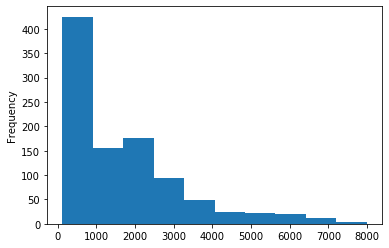

In [13]:
dataframe["price"].plot(kind="hist")

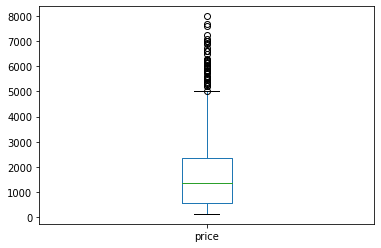

In [14]:
dataframe["price"].plot(kind="box")

Распределение длины (количество слов) описаний (уже обработанных, без стоп-слов, без пунктуации, лемматизированных), гистограмма и боксплот. Больше всего описаний, длиной до 50 слов.

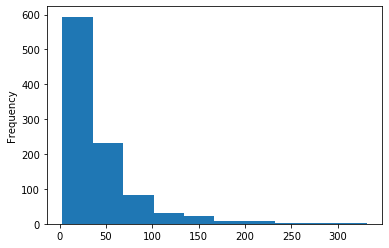

In [15]:
len_descr = [len(descr.split(" ")) for descr in dataframe["lemmatized_description"]]
len_descr = pd.Series(len_descr)
len_descr.plot(kind="hist")

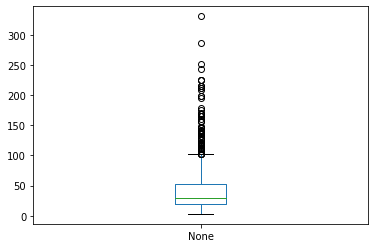

In [16]:
len_descr.plot(kind="box")

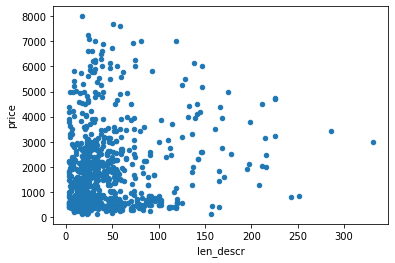

In [17]:
dataframe["len_descr"] = len_descr
dataframe.plot.scatter(x="len_descr", y="price")

Если попробовать взять длину не по количеству слов в обработанных описаниях, а просто посимвольную длину описаний, в принципе ничего не меняется

In [18]:
dataframe["len_descr_symbol"] = [len(description) for description in dataframe["product_description"]]

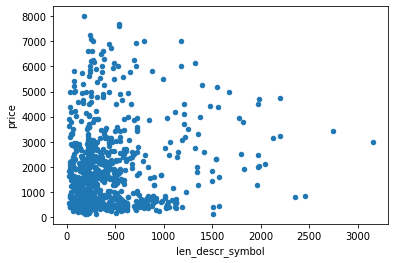

In [19]:
dataframe.plot.scatter(x="len_descr_symbol", y="price")

Цена и количество оценок товара


Несколько товаров с очень большим количеством отзывов всё портят и ничего непонятно, но ощущение, как будто чем дешевле товар, тем больше отзывов о нем есть (то есть, о дорогих товарах меньше отзывов, о более дешевых, больше)

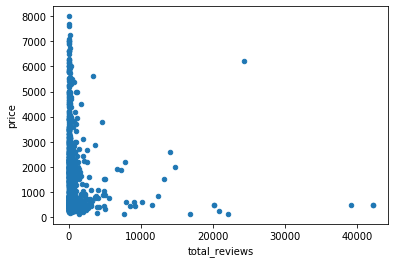

In [20]:
dataframe.plot.scatter(x="total_reviews", y="price")

Цена и общая оценка товара


В целом, немного заметно, что за исключением некоторых выбросов, более дорогие товары оценивают выше

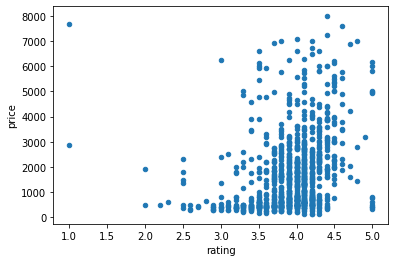

In [21]:
dataframe.plot.scatter(x="rating", y="price")

Можно заметить, что классы оценок тоже распределены неравномерно: в целом все оценки распределены в диапазоне от 3 до 5, оценки около 4 встречаются чаще всего

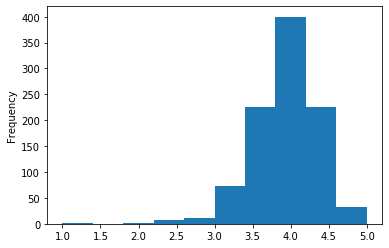

In [22]:
dataframe["rating"].plot(kind="hist")

Более наглядное распределение оценок

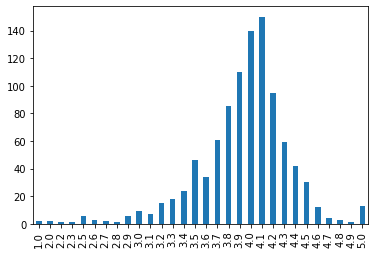

In [23]:
dataframe['rating'].value_counts().sort_index().plot.bar()

В целом, судя по цифрам, корреляции небольшие, но как будто у более дорогих товаров более высокие оценки; у более дорогих товаров меньшее количество оценок/отзывов; описание более дорогих товаров длиннее

In [24]:
dataframe.corr()

,price,rating,total_reviews,len_descr,len_descr_symbol
price,1.000000,0.271582,-0.094865,0.135875,0.123566
rating,0.271582,1.000000,0.066541,0.046575,0.038633
total_reviews,-0.094865,0.066541,1.000000,0.093094,0.097005
len_descr,0.135875,0.046575,0.093094,1.000000,0.993859
len_descr_symbol,0.123566,0.038633,0.097005,0.993859,1.000000


In [25]:
dataframe.describe()

,price,rating,total_reviews,len_descr,len_descr_symbol
count,982.000000,982.000000,982.000000,982.000000,982.000000
mean,1735.354379,3.934318,803.661914,42.294297,408.197556
std,1510.806956,0.422185,3082.243380,40.160229,383.152373
min,127.000000,1.000000,1.000000,3.000000,18.000000
25%,560.000000,3.800000,27.000000,20.000000,194.250000
50%,1339.500000,4.000000,127.000000,29.000000,278.500000
75%,2342.500000,4.200000,473.000000,53.000000,512.000000
max,7992.000000,5.000000,42193.000000,331.000000,3157.000000


График плотности цен для мужской и женской обуви

In [26]:
men_shoes = dataframe[dataframe["Shoe Type"] == "Men"]
women_shoes = dataframe[dataframe["Shoe Type"] == "Women"]

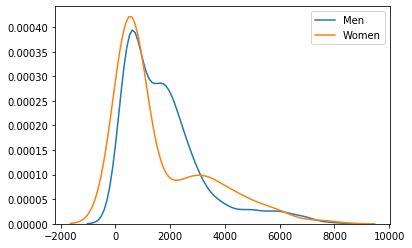

In [27]:
sns.kdeplot(men_shoes["price"], label="Men")
sns.kdeplot(women_shoes["price"], label="Women")

### Задание 1

#### TF-IDF векторайзер

In [28]:
X1 = vectorizer1.fit_transform(list(dataframe["lemmatized_description"]))
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, list(dataframe['price']), test_size=0.70, random_state=42)

#### CountVectorizer

In [29]:
X2 = vectorizer2.fit_transform(list(dataframe["lemmatized_description"]))
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, list(dataframe['price']), test_size=0.70, random_state=42)

#### Модели

Мы будем рассматривать такие модели как Линейная регрессия, Lasso, Ridge и ElasticNet.

#### Линейная регрессия

Сделаем функцию, в которой будем проводить гридсёрч для линейной регрессии, для определения лучших параметров

In [66]:
import warnings
warnings.filterwarnings("ignore")

def linear_regression(X_train, Y_train):
    model = LinearRegression()
    param_grid = {'fit_intercept': [True, False],
                  'normalize': [True, False],
                  'copy_X': [True, False],
                  'positive': [True, False]}
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
    search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=cv)
    result = search.fit(X_train, Y_train)
    print("Best model score: ", result.best_score_)
    print("Best model parameters: ", result.best_params_)

Определение лучших параметров для линейной регрессии, данные векторизованы с помощью TF-IDF векторайзера

In [67]:
linear_regression(X1_train, Y1_train)

Best model score:  -3385325.5907579516
Best model parameters:  {'copy_X': True, 'fit_intercept': False, 'normalize': True, 'positive': False}


Определение лучших параметров для линейной регрессии, данные векторизованы с помощью CountVectorizer

In [68]:
linear_regression(X2_train, Y2_train)

Best model score:  -4203877.955791475
Best model parameters:  {'copy_X': True, 'fit_intercept': False, 'normalize': True, 'positive': False}


В целом, кажется, почему-то у моделей очень плохое качество. Может быть, слишком мало данных. Но при этом с данными, векторизованными TF-IDF векторайзером, результат чуть лучше

Функция, которая возвращает разные оценки для полученного результата работы модели

In [70]:
def score(Y_test, Y_pred):
    print('MSE: ', mean_squared_error(Y_test, Y_pred, squared=False))  # 0 - best
    print('MAE: ', mean_absolute_error(Y_test, Y_pred))  # 0 - best
    print('EVS: ', explained_variance_score(Y_test, Y_pred))  # 1 - best
    print('ME: ', max_error(Y_test, Y_pred))  # 0 - best
    print('R2: ', r2_score(Y_test, Y_pred))  # 1 - best
    print('MAPE: ', mean_absolute_percentage_error(Y_test, Y_pred))  # 0 - best

In [81]:
lr_TFIDF = LinearRegression(copy_X=True, fit_intercept=False, normalize=True, positive=False).fit(X1_train, Y1_train)
Y1_pred_lr = lr_TFIDF.predict(X1_test)
score(Y1_test, Y1_pred_lr)

MSE:  1441.5686468771612
MAE:  950.745630273873
EVS:  0.0715686763245098
ME:  6473.280352986577
R2:  0.04571304033276091
MAPE:  0.7281914400667786


In [82]:
lr_Count = LinearRegression(copy_X=True, fit_intercept=False, normalize=True, positive=False).fit(X2_train, Y2_train)
Y2_pred_lr = lr_Count.predict(X2_test)
score(Y2_test, Y2_pred_lr)

MSE:  2290.2999056114127
MAE:  1481.7814007627967
EVS:  -1.4077003598504803
ME:  15261.775703627354
R2:  -1.4087572972455558
MAPE:  1.2756362592835722


#### Lasso

Сделаем функцию, в которой будем проводить гридсёрч для Lasso, для определения лучших параметров. Если запускать гридсёрч по всем параметрам, это занимает нереальное количество времени, поэтому оставляем в param_grid только 'alpha'

In [76]:
def lasso(X_train, Y_train):
    model = Lasso()
    param_grid = {#'fit_intercept': [True, False],
                  #'normalize': [True, False],
                  #'copy_X': [True, False],
                  #'positive': [True, False],
                  #'precompute': [True, False],
                  #'selection': ['cyclic', 'random'],
                  'alpha': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]}
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
    search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=cv)
    result = search.fit(X_train, Y_train)
    print("Best model score: ", result.best_score_)
    print("Best model parameters: ", result.best_params_)

In [77]:
lasso(X1_train, Y1_train)

Best model score:  -1746174.9769850862
Best model parameters:  {'alpha': 1}


In [78]:
lasso(X2_train, Y2_train)

Best model score:  -1939396.7355127952
Best model parameters:  {'alpha': 10}


Посмотрим на оценки моделей с лучшими параметрами. Стоит заметить, что, когда векторайзер - TF-IDF, оценки снова чуть лучше

In [83]:
lasso_TFIDF = Lasso(alpha=1).fit(X1_train, Y1_train)
Y1_pred_lasso = lasso_TFIDF.predict(X1_test)
score(Y1_test, Y1_pred_lasso)

MSE:  1246.6096247384237
MAE:  852.0843531741875
EVS:  0.28694237158626135
ME:  5095.012099730344
R2:  0.2863762681524862
MAPE:  0.7563813025655686


In [84]:
lasso_Count = Lasso(alpha=10).fit(X2_train, Y2_train)
Y2_pred_lasso = lasso_Count.predict(X2_test)
score(Y2_test, Y2_pred_lasso)

MSE:  1279.9392546835786
MAE:  892.9567930306107
EVS:  0.2488956474352293
ME:  7209.219327197361
R2:  0.24770694865825993
MAPE:  0.8830316327776705


#### Ridge

Гридсерч для Ridge

In [85]:
def ridge(X_train, Y_train):
    model = Ridge()
    param_grid = {'fit_intercept': [True, False],
                  'normalize': [True, False],
                  'positive': [True, False],
                  'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'],
                  'alpha': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]}
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
    search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=cv)
    result = search.fit(X_train, Y_train)
    print("Best model score: ", result.best_score_)
    print("Best model parameters: ", result.best_params_)

In [86]:
ridge(X1_train, Y1_train)

Best model score:  -1568951.1749998087
Best model parameters:  {'alpha': 0.1, 'fit_intercept': True, 'normalize': False, 'positive': False, 'solver': 'auto'}


In [87]:
ridge(X2_train, Y2_train)

Best model score:  -1722424.2434996688
Best model parameters:  {'alpha': 10, 'fit_intercept': True, 'normalize': False, 'positive': False, 'solver': 'sag'}


Посмотрим на оценки моделей с лучшими параметрами. Стоит заметить, что, когда векторайзер - TF-IDF, оценки снова чуть лучше

In [88]:
ridge_TFIDF = Ridge(alpha=0.1, fit_intercept=True, normalize=False, positive=False, solver='auto').fit(X1_train, Y1_train)
Y1_pred_ridge = ridge_TFIDF.predict(X1_test)
score(Y1_test, Y1_pred_ridge)

MSE:  1160.4004694206994
MAE:  803.1345772907325
EVS:  0.3835488815371003
ME:  5242.778258174489
R2:  0.3816645803192542
MAPE:  0.760864792734605


In [89]:
ridge_Count = Ridge(alpha=10, fit_intercept=True, normalize=False, positive=False, solver='sag').fit(X2_train, Y2_train)
Y2_pred_ridge = ridge_Count.predict(X2_test)
score(Y2_test, Y2_pred_ridge)

MSE:  1207.202402492219
MAE:  841.7086311290594
EVS:  0.33231525162275855
ME:  5165.539999741811
R2:  0.3307806109769301
MAPE:  0.8589864320330851


Пока судя по оценкам, Ridge справляется лучше всех. Плохо, но лучше, чем линейная регрессия и Lasso

#### ElasticNet

Гридсерч для ElasticNet. Так же, как и для Lasso, оставлять все параметры нет смысла, плюс гридсёрч будет работать очень долго, поэтому оставляем только 'alpha' и 'l1_ratio'.

In [90]:
def elastic(X_train, Y_train):
    model = ElasticNet()
    param_grid = {'l1_ratio': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                  'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
    search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=cv)
    result = search.fit(X_train, Y_train)
    print("Best model score: ", result.best_score_)
    print("Best model parameters: ", result.best_params_)

In [91]:
elastic(X1_train, Y1_train)

Best model score:  -1549920.4252268788
Best model parameters:  {'alpha': 0.01, 'l1_ratio': 0.9}


In [92]:
elastic(X2_train, Y2_train)

Best model score:  -1713172.5162423444
Best model parameters:  {'alpha': 1, 'l1_ratio': 0.9}


Посмотрим на оценки моделей с лучшими параметрами. Стоит заметить, что, когда векторайзер - TF-IDF, оценки, как и в предыдущих моделях, лучше.

In [94]:
elastic_TFIDF = ElasticNet(alpha=0.01, l1_ratio=0.9).fit(X1_train, Y1_train)
Y1_pred_elastic = elastic_TFIDF.predict(X1_test)
score(Y1_test, Y1_pred_elastic)

MSE:  1138.4474077455966
MAE:  796.3919843178544
EVS:  0.4069279288249358
ME:  5282.0755430981
R2:  0.4048392559363443
MAPE:  0.775891077972288


In [95]:
elastic_Count = ElasticNet(alpha=1, l1_ratio=0.9).fit(X2_train, Y2_train)
Y2_pred_elastic = elastic_Count.predict(X2_test)
score(Y2_test, Y2_pred_elastic)

MSE:  1172.678579131037
MAE:  840.6133689263986
EVS:  0.37138062553957774
ME:  5167.909904524666
R2:  0.3685102332490193
MAPE:  0.8969755812007237


#### Итог

Если смотреть, например, на MSE, MAE и R2, получится что с небольшим отрывом но побеждает модель ElasticNet, если данные векторизованы с помощью TF-IDF векторайзера.
Попробуем изобразить все получившиеся модели (c TF-IDF векторайзером) в виде боксплотов для наглядности

In [97]:
df_price = pd.DataFrame()
df_price["price"] = Y1_test
df_price["price_pred_lr"] = Y1_pred_lr
df_price["price_pred_lasso"] = Y1_pred_lasso
df_price["price_pred_ridge"] = Y1_pred_ridge
df_price["price_pred_elastic"] = Y1_pred_elastic

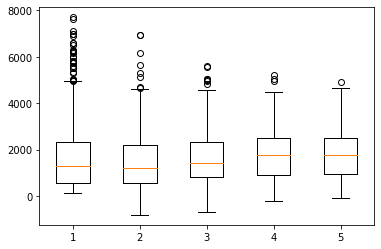

In [106]:
plt.boxplot([df_price["price"], df_price["price_pred_lr"], df_price["price_pred_lasso"], df_price["price_pred_ridge"], df_price["price_pred_elastic"]])
plt.show()

По графику трудно сказать, у какой модели предсказать цену получилось лучше всего. Всё-таки объем данных маленький. Хотя возможно, ElasticNet действительно приближена к реальным данным больше всего. Почему так могло выйти, к сожалению я не знаю. Раньше я никогда не сталкивалась с этой моделью.

Зато по графику хорошо заметны две проблемы, существующие у всех моделей. Во-первых, все они предсказывают отрицательные цены. В дальнейшем надо каким-то образом создать ограничение на возможность предсказания отрицательных цен. А кроме того, все модели очень плохо работают с существующими выбросами. Это тоже хорошо отображает график. Как быть с этим непонятно. Если убирать их, данных станет совсем мало и это только ухудшит ситуацию.

In [107]:
df_price.describe()

,price,price_pred_lr,price_pred_lasso,price_pred_ridge,price_pred_elastic
count,688.000000,688.000000,688.000000,688.000000,688.000000
mean,1715.511628,1478.224901,1680.400585,1779.569277,1782.953722
std,1476.765997,1159.711152,1030.103317,961.423369,883.258007
min,129.000000,-813.122354,-696.012100,-219.863243,-75.305251
25%,559.000000,558.799995,835.045820,905.800241,964.403439
50%,1299.000000,1218.393178,1421.392731,1761.170890,1765.975224
75%,2315.500000,2190.966072,2341.450174,2515.022799,2485.178198
max,7702.000000,6918.937244,5589.009929,5214.251045,4930.330533


Если смотреть на такие параметры как среднее, максимальное и минимальное значения, то к среднему ближе всего оказалась Lasso, к максимальному - линейная регрессия, к минимальному - ElasticNet

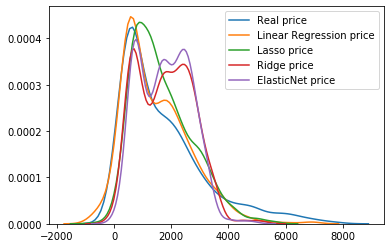

In [109]:
sns.kdeplot(df_price["price"], label="Real price")
sns.kdeplot(df_price["price_pred_lr"], label="Linear Regression price")
sns.kdeplot(df_price["price_pred_lasso"], label="Lasso price")
sns.kdeplot(df_price["price_pred_ridge"], label="Ridge price")
sns.kdeplot(df_price["price_pred_elastic"], label="ElasticNet price")

Если посмотреть на график плотности, самым близким к графику реальных цен получится график линейной регрессии.

##### Ещё раз итог
Подводя итог, мне трудно понять, по каким параметрам стоит определять, какая модель предсказала цену лучше всего.

Однако очевидно, что у моделей есть такие проблемы как предсказывание отрицательных цен, и трудности с предсказыванием больших выбросов.

### Задание 2

Возьмем из таблицы только колонки с отзывами и их оценками и приведем их в подходящий формат

In [112]:
list_reviews = [cell.split('||') for cell in dataframe["reviews"]]
reviews = sum(list_reviews, [])

In [124]:
list_ratings = [cell.split('||') for cell in dataframe["reviews_rating"]]
ratings = sum(list_ratings, [])
ratings = [rating.split(' ')[1] 
           if rating[0] == ' ' 
           else rating.split(' ')[0] 
           for rating in ratings]
ratings = [float(rating.split('.')[0]) + int(rating.split('.')[1]) / 10 for rating in ratings]

In [125]:
df_task2 = pd.DataFrame({"reviews": reviews,
                         "ratings": ratings})

Приведем к нижнему регистру, лемматизируем отзывы, уберем в них пунктуацию

In [127]:
lemmatized_reviews = []
for index, review in enumerate(df_task2["reviews"]):
    for item in punctuation:  # убираем пунктуацию
        without_punct = review.replace(item, '')
        review = without_punct
    tokenized_review = nltk.word_tokenize(review.lower())  # токенизируем и приводим к нижнему регистру
    lemmatized_review = [lemmatizer.lemmatize(token) for token in tokenized_review]  # лемматизируем
    without_stopwords = []
    for word in lemmatized_review:  # убираем стоп-слова
        if word not in stopwords.words('english'):
            without_stopwords.append(word)
    lemmatized_reviews.append(' '.join(without_stopwords))

df_task2["reviews"]= lemmatized_reviews

for index, review in enumerate(df_task2["reviews"]):  # чистим от пустых отзывов
    if review == '':
        df_task2 = df_task2.drop(index)
df_task2 = df_task2.reset_index(drop = True)

In [128]:
df_task2

,reviews,ratings
0,happy product,1.0
1,expected,1.0
2,average product,3.0
3,pic beautiful,3.0
4,got damage product quality average 300₹,3.0
...,...,...
7954,go,5.0
7955,excellent product,5.0
7956,nice shoe,5.0
7957,nice,5.0


Будет не очень информативно, но всё же

In [129]:
df_task2.describe()

,ratings
count,7959.000000
mean,3.705868
std,1.548919
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


Количество оценок распределено неравномерно

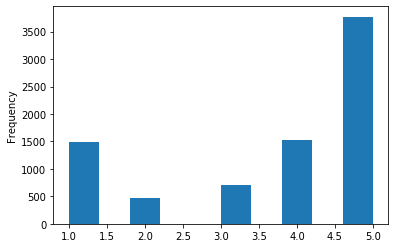

In [130]:
df_task2["ratings"].plot(kind="hist")

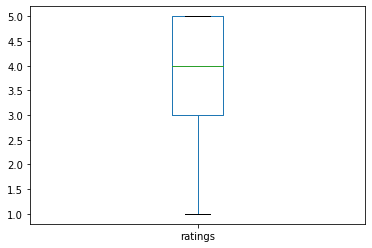

In [131]:
df_task2["ratings"].plot(kind="box")

#### TF-IDF векторайзер

In [136]:
X3 = vectorizer1.fit_transform(list(df_task2["reviews"]))
X3_train, X3_test, Y3_train, Y3_test = train_test_split(X3, list(df_task2["ratings"]), test_size=0.70, random_state=42)

#### CountVectorizer

In [137]:
X4 = vectorizer2.fit_transform(list(df_task2["reviews"]))
X4_train, X4_test, Y4_train, Y4_test = train_test_split(X4, list(df_task2["ratings"]), test_size=0.70, random_state=42)

#### Модели

Мы будем рассматривать такие модели как Логистическая регрессия, KNN, Random Forest и Ridge Classifier

#### LogisticRegression

In [142]:
def logistic_regression(X_train, Y_train):
    model = LogisticRegression()
    param_grid = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                  'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                  #'multi_class': ['auto', 'ovr', 'multinomial'],
                  #'l1_ratio': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                  'C': [1e-2, 1e-1, 1, 10, 100]}
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
    search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1_macro', n_jobs=-1, cv=cv)
    result = search.fit(X_train, Y_train)
    print("Best model score: ", result.best_score_)
    print("Best model parameters: ", result.best_params_)

In [143]:
logistic_regression(X3_train, Y3_train)

Best model score:  0.36281866039926813
Best model parameters:  {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


In [144]:
logistic_regression(X4_train, Y4_train)

Best model score:  0.3667946078135633
Best model parameters:  {'C': 10, 'penalty': 'l2', 'solver': 'saga'}


Функция, выдающая оценку модели по разным параметрам

In [145]:
def score2(Y_test, Y_pred):
    print('Accuracy: ', accuracy_score(Y_pred, Y_test))
    print('Micro F1: ', f1_score(Y_pred, Y_test, average = 'micro'))
    print('Micro Precision: ', precision_score(Y_pred, Y_test, average = 'micro'))
    print('Micro Recall: ', recall_score(Y_pred, Y_test, average = 'micro'))
    print('Macro F1: ', f1_score(Y_pred, Y_test, average = 'macro'))
    print('Macro Precision: ', precision_score(Y_pred, Y_test, average = 'macro'))
    print('Macro Recall: ', recall_score(Y_pred, Y_test, average = 'macro'))

In [146]:
LogR_TFIDF = LogisticRegression(C=10, penalty='l2', solver='liblinear').fit(X3_train, Y3_train)
LogR_TFIDF_pred = LogR_TFIDF.predict(X3_test)
score2(LogR_TFIDF_pred, Y3_test)

Accuracy:  0.58183776022972
Micro F1:  0.58183776022972
Micro Precision:  0.58183776022972
Micro Recall:  0.58183776022972
Macro F1:  0.36115230949750254
Macro Precision:  0.4185096714569651
Macro Recall:  0.3642075697958681


In [147]:
LogR_Count = LogisticRegression(C=10, penalty='l2', solver='saga').fit(X4_train, Y4_train)
LogR_Count_pred = LogR_Count.predict(X4_test)
score2(LogR_Count_pred, Y4_test)

Accuracy:  0.573402727925341
Micro F1:  0.573402727925341
Micro Precision:  0.573402727925341
Micro Recall:  0.573402727925341
Macro F1:  0.3684978222522618
Macro Precision:  0.4151088890702349
Macro Recall:  0.36665589925473163


Тут как будто разница между векторайзерами меньше заметна (в отличие от моделей, которые предсказывали цену в первом задании)

#### KNN

In [149]:
def knn(X_train, Y_train):
    model = KNeighborsClassifier()
    param_grid = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                  'weights': ['uniform', 'distance'],
                  #'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'] - auto сам выбирает более подходящий алгоритм
                  'p': [1,2],
                  'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski', 'wminkowski', 'seuclidean', 'mahalanobis']}
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
    search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1_macro', n_jobs=-1, cv=cv)
    result = search.fit(X_train, Y_train)
    print("Best model score: ", result.best_score_)
    print("Best model parameters: ", result.best_params_)

In [150]:
knn(X3_train, Y3_train)

Best model score:  0.3317643919098792
Best model parameters:  {'metric': 'euclidean', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}


In [151]:
knn(X4_train, Y4_train)

Best model score:  0.34716604216064134
Best model parameters:  {'metric': 'euclidean', 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}


In [152]:
knn_TFIDF = KNeighborsClassifier(metric='euclidean', n_neighbors=5, p=1, weights='distance').fit(X3_train, Y3_train)
knn_TFIDF_pred = knn_TFIDF.predict(X3_test)
score2(knn_TFIDF_pred, Y3_test)

Accuracy:  0.4996410624551328
Micro F1:  0.4996410624551328
Micro Precision:  0.4996410624551328
Micro Recall:  0.4996410624551328
Macro F1:  0.3604180115303253
Macro Precision:  0.39513828795109035
Macro Recall:  0.3540533593229969


In [154]:
knn_Count = KNeighborsClassifier(metric='euclidean', n_neighbors=10, p=1, weights='distance').fit(X4_train, Y4_train)
knn_Count_pred = knn_Count.predict(X4_test)
score2(knn_Count_pred, Y4_test)

Accuracy:  0.5371500358937545
Micro F1:  0.5371500358937545
Micro Precision:  0.5371500358937545
Micro Recall:  0.5371500358937545
Macro F1:  0.37165920867774627
Macro Precision:  0.44603971769655465
Macro Recall:  0.3567329515916738


А в случае с KNN небольшая разница между векторайзерами заметна. И в данном случае CountVectorizer оказывается чуть лучше (если смотреть на accuracy)

#### Ridge Classifier

In [156]:
def ridgeclass(X_train, Y_train):
    model = RidgeClassifier()
    param_grid = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0],
                  'solver': ['newton-cg', 'lbfgs', 'lsqr', 'sag', 'saga', 'auto', 'svd', 'cholesky', 'sparse_cg'],
                  'fit_intercept': [True, False],
                  'normalize': [True, False]}
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
    search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1_macro', n_jobs=-1, cv=cv)
    result = search.fit(X_train, Y_train)
    print("Best model score: ", result.best_score_)
    print("Best model parameters: ", result.best_params_)

In [157]:
ridgeclass(X3_train, Y3_train)

Best model score:  0.38254998514368255
Best model parameters:  {'alpha': 0.1, 'fit_intercept': True, 'normalize': True, 'solver': 'sag'}


In [158]:
ridgeclass(X4_train, Y4_train)

Best model score:  0.39553455609165983
Best model parameters:  {'alpha': 1.0, 'fit_intercept': True, 'normalize': True, 'solver': 'sag'}


In [159]:
ridgeclass_TFIDF = RidgeClassifier(alpha=0.1, fit_intercept=True, normalize=True, solver='sag').fit(X3_train, Y3_train)
ridgeclass_TFIDF_pred = ridgeclass_TFIDF.predict(X3_test)
score2(ridgeclass_TFIDF_pred, Y3_test)

Accuracy:  0.5450466618808327
Micro F1:  0.5450466618808327
Micro Precision:  0.5450466618808327
Micro Recall:  0.5450466618808327
Macro F1:  0.39904720016420864
Macro Precision:  0.43221060433649994
Macro Recall:  0.3892733518028855


In [160]:
ridgeclass_Count = RidgeClassifier(alpha=1.0, fit_intercept=True, normalize=True, solver='sag').fit(X4_train, Y4_train)
ridgeclass_Count_pred = ridgeclass_Count.predict(X4_test)
score2(ridgeclass_Count_pred, Y4_test)

Accuracy:  0.547559224694903
Micro F1:  0.547559224694903
Micro Precision:  0.547559224694903
Micro Recall:  0.547559224694903
Macro F1:  0.39450948612385384
Macro Precision:  0.4334382376012232
Macro Recall:  0.3926256454570827


Пока кажется, из всех моделей лучшие результаты у логистической регрессии

#### Decision Tree

In [168]:
def decisiontree(X_train, Y_train):
    model = DecisionTreeClassifier()
    param_grid = {'criterion': ['gini', 'entropy'],
                  'splitter': ['best', 'random'],
                  'max_features': ['auto', 'sqrt', 'log2', None]}
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
    search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1_macro', n_jobs=-1, cv=cv)
    result = search.fit(X_train, Y_train)
    print("Best model score: ", result.best_score_)
    print("Best model parameters: ", result.best_params_)

In [169]:
decisiontree(X3_train, Y3_train)

Best model score:  0.35589803979545453
Best model parameters:  {'criterion': 'entropy', 'max_features': None, 'splitter': 'best'}


In [170]:
decisiontree(X4_train, Y4_train)

Best model score:  0.3578449064592125
Best model parameters:  {'criterion': 'gini', 'max_features': None, 'splitter': 'random'}


In [171]:
decisiontree_TFIDF = DecisionTreeClassifier(criterion='entropy', max_features=None, splitter='best').fit(X3_train, Y3_train)
decisiontree_TFIDF_pred = decisiontree_TFIDF.predict(X3_test)
score2(decisiontree_TFIDF_pred, Y3_test)

Accuracy:  0.5522254127781766
Micro F1:  0.5522254127781766
Micro Precision:  0.5522254127781766
Micro Recall:  0.5522254127781766
Macro F1:  0.3738901708641394
Macro Precision:  0.41487565523563247
Macro Recall:  0.36554828743095014


In [172]:
decisiontree_Count = DecisionTreeClassifier(criterion='gini', max_features=None, splitter='random').fit(X4_train, Y4_train)
decisiontree_Count_pred = decisiontree_Count.predict(X4_test)
score2(decisiontree_Count_pred, Y4_test)

Accuracy:  0.5536611629576453
Micro F1:  0.5536611629576453
Micro Precision:  0.5536611629576453
Micro Recall:  0.5536611629576453
Macro F1:  0.37345728787082316
Macro Precision:  0.4152322263410551
Macro Recall:  0.3664806928434663


#### Random Forest

In [162]:
def randomforest(X_train, Y_train):
    model = RandomForestClassifier()
    param_grid = {'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                  'criterion': ['gini', 'entropy'],
                  'max_features': ['auto', 'sqrt', 'log2'],
                  'class_weight': ['balanced', 'balanced_subsample']}
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
    search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1_macro', n_jobs=-1, cv=cv)
    result = search.fit(X_train, Y_train)
    print("Best model score: ", result.best_score_)
    print("Best model parameters: ", result.best_params_)

In [163]:
randomforest(X3_train, Y3_train)

Best model score:  0.3854858857115262
Best model parameters:  {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 80}


In [164]:
randomforest(X4_train, Y4_train)

Best model score:  0.37834526665590557
Best model parameters:  {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 50}


In [165]:
randomforest_TFIDF = RandomForestClassifier(n_estimators=80, criterion='entropy', max_features='auto', class_weight='balanced_subsample').fit(X3_train, Y3_train)
randomforest_TFIDF_pred = randomforest_TFIDF.predict(X3_test)
score2(randomforest_TFIDF_pred, Y3_test)

Accuracy:  0.5073582196697775
Micro F1:  0.5073582196697775
Micro Precision:  0.5073582196697775
Micro Recall:  0.5073582196697775
Macro F1:  0.385934043434007
Macro Precision:  0.4128531100310348
Macro Recall:  0.3834946710100483


In [167]:
randomforest_Count = RandomForestClassifier(n_estimators=50, criterion='entropy', max_features='auto', class_weight='balanced').fit(X4_train, Y4_train)
randomforest_Count_pred = randomforest_Count.predict(X4_test)
score2(randomforest_Count_pred, Y4_test)

Accuracy:  0.4858219669777459
Micro F1:  0.4858219669777459
Micro Precision:  0.4858219669777459
Micro Recall:  0.4858219669777459
Macro F1:  0.3749660383778088
Macro Precision:  0.3810283542761931
Macro Recall:  0.37705463368743003


#### Оценка моделей с помощью confusion matrix

Для матрицы в каждом случае выбирались чуть более лучшие модели (по accuracy). Если результат по данным, векторизованным tf-idf, был лучше, то выбирался он, если же нет, то соответственно выбирался другой.

In [177]:
confusion_matrix_LogR = confusion_matrix(y_true=Y3_test, y_pred=LogR_TFIDF_pred)
df1 = pd.DataFrame(confusion_matrix_LogR,
                     index = [1, 2, 3, 4, 5], 
                     columns = [1, 2, 3, 4, 5])
df1

,1,2,3,4,5
1,648,30,33,40,305
2,104,17,36,35,137
3,87,16,67,62,259
4,68,17,43,121,806
5,77,6,33,136,2389


In [178]:
confusion_matrix_knn = confusion_matrix(y_true=Y4_test, y_pred=knn_Count_pred)
df2 = pd.DataFrame(confusion_matrix_knn,
                     index = [1, 2, 3, 4, 5], 
                     columns = [1, 2, 3, 4, 5])
df2

,1,2,3,4,5
1,531,30,19,68,408
2,89,31,20,42,147
3,57,21,63,86,264
4,56,15,28,284,672
5,115,12,21,409,2084


In [179]:
confusion_matrix_ridgeclass = confusion_matrix(y_true=Y4_test, y_pred=ridgeclass_Count_pred)
df3 = pd.DataFrame(confusion_matrix_ridgeclass,
                     index = [1, 2, 3, 4, 5], 
                     columns = [1, 2, 3, 4, 5])
df3

,1,2,3,4,5
1,674,35,30,110,207
2,114,18,33,77,87
3,90,16,78,159,148
4,64,9,44,435,503
5,132,4,39,620,1846


In [180]:
confusion_matrix_tree = confusion_matrix(y_true=Y4_test, y_pred=decisiontree_Count_pred)
df4 = pd.DataFrame(confusion_matrix_tree,
                     index = [1, 2, 3, 4, 5], 
                     columns = [1, 2, 3, 4, 5])
df4

,1,2,3,4,5
1,579,60,42,44,331
2,99,40,31,23,136
3,85,25,81,58,242
4,60,43,42,166,744
5,111,35,44,232,2219


In [181]:
confusion_matrix_forest = confusion_matrix(y_true=Y3_test, y_pred=randomforest_TFIDF_pred)
df5 = pd.DataFrame(confusion_matrix_forest,
                     index = [1, 2, 3, 4, 5], 
                     columns = [1, 2, 3, 4, 5])
df5

,1,2,3,4,5
1,604,133,39,66,214
2,97,68,32,50,82
3,82,72,67,94,176
4,59,86,33,372,505
5,97,207,21,600,1716


#### Итог

В целом, подводя итог, можно сказать, что некоторые модели лучше определяют одни классы оценок, а другие - соответственно другие. 


Но среди рассмотренных моделей в качестве лучших можно выделить модель логистической регрессии и Ridge Classifier. При этом, по-моему, логистическая регрессия справилась чуть лучше.


Можно отметить, что логистической регрессией лучше определяются оценки 5, а Ridge лучше определяет 4 и 1.

При этом из общих недостатков можно отметить, что почему-то все модели достаточно часто путают оценки 4 и 5 (как пятерку с четверкой, так и наоборот), а также часто вместо 1, отзыв определяется как 5.